# Fashion Trend Forecasting with ML Pipelines Using an SGD Classifier

# 1. Project Overview

This project aims to build a machine learning pipeline to predict product recommendations from customer reviews for "StyleSense," a rapidly growing online women's clothing store known for its trendy and affordable fashion.

The model analyzes review text, customer age, product category, and other relevant features to predict whether a customer would recommend a product. By automating this process, we aim to gain insights into customer satisfaction, identify trending products, and support data-driven decisions for the retailer.


***Note:*** In this notebook, we implement the model using an ***SGDClassifier***. Other notebooks implement the same task using a LinearSVC and a Random Forest classifier.






# 2. Data Understanding

## Data Loading 

In [1]:
import pandas as pd

# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Data Structure 

***Note:*** The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.


The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.


The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Initial Analysis: Top Products by Review Count and Recommendation Rate

This section calculates the number of recommended reviews and the recommendation rate for each product.
Products with fewer than 10 reviews are excluded from the analysis.
The top products are displayed as tables and visualized using horizontal bar charts, showing both the count of recommendations and the recommendation rate.


In [2]:
# Group by product and aggregate both count and recommendation rate
product_stats = df.groupby('Clothing ID')['Recommended IND'].agg(
    recommended_count='sum',  # Number of recommended reviews
    total_reviews='count'      # Total number of reviews
)

# Calculate recommendation rate
product_stats['recommended_rate'] = product_stats['recommended_count'] / product_stats['total_reviews']

# Set minimum number of reviews to consider
min_reviews = 10

# Filter products with at least min_reviews
product_stats_filtered = product_stats[product_stats['total_reviews'] >= min_reviews]

# Sort by recommended_count descending
product_stats_sorted = product_stats.sort_values(by='recommended_count', ascending=False)

# Display top 10
from IPython.display import display
display(product_stats_sorted.head(10))

# Sort by recommendation rate descending
product_stats_filtered_sorted = product_stats_filtered.sort_values(by='recommended_rate', ascending=False)

# Display top 10 products as a table
display(product_stats_filtered_sorted.head(10))


,recommended_count,total_reviews,recommended_rate
Clothing ID,,,
1078,707,871,0.811711
862,534,658,0.811550
1094,533,651,0.818740
1081,415,487,0.852156
872,386,450,0.857778
829,373,452,0.825221
1110,345,419,0.823389
895,280,336,0.833333
868,274,370,0.740541


,recommended_count,total_reviews,recommended_rate
Clothing ID,,,
1135,10,10,1.000000
417,10,10,1.000000
1123,25,25,1.000000
1026,16,16,1.000000
674,14,14,1.000000
1036,17,17,1.000000
1024,27,28,0.964286
960,22,23,0.956522
964,62,65,0.953846


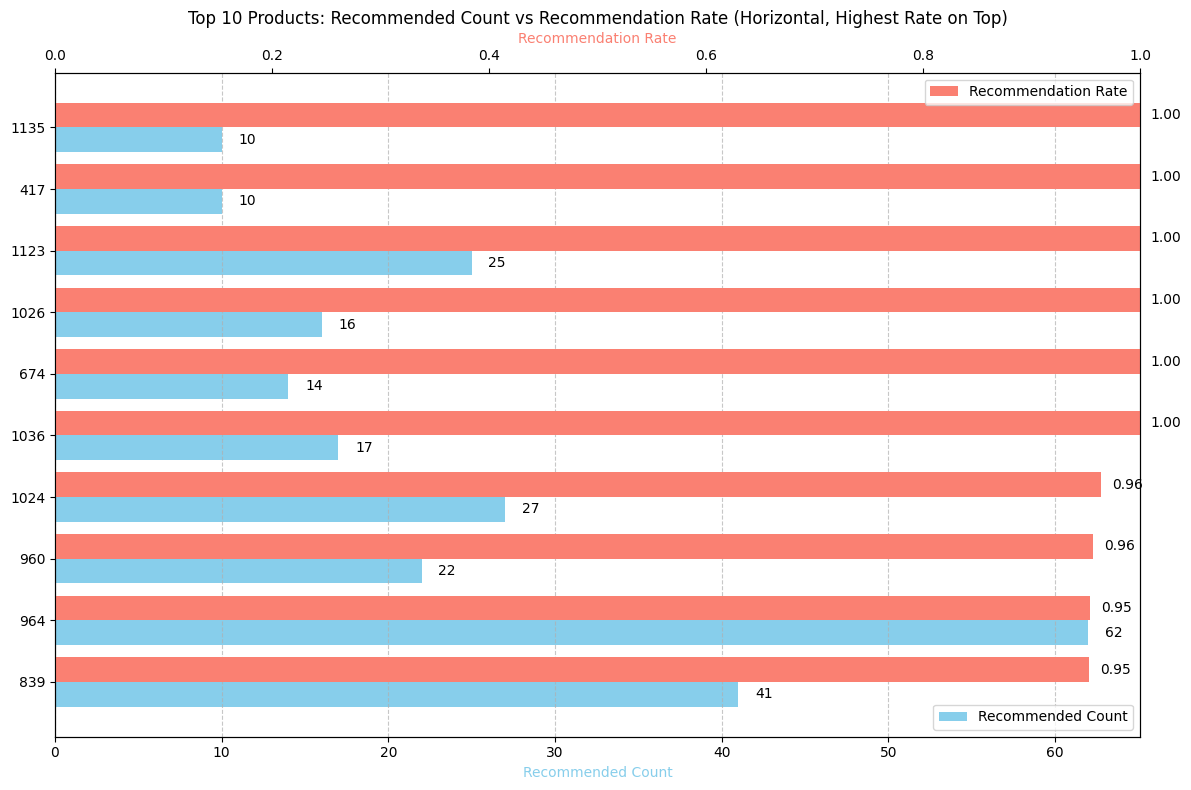

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Top products by recommendation rate (minimum 10 reviews)
top_products = product_stats[product_stats['total_reviews'] >= 10].sort_values(by='recommended_rate', ascending=False).head(10)

# Reverse order for plotting so highest rate is on top
top_products = top_products.iloc[::-1]

product_ids = top_products.index.tolist()
recommended_count = top_products['recommended_count'].values
recommended_rate = top_products['recommended_rate'].values

bar_height = 0.4
y = np.arange(len(product_ids))

fig, ax = plt.subplots(figsize=(12,8))

# Horizontal bars for recommended count
bars_count = ax.barh(y - bar_height/2, recommended_count, height=bar_height, color='skyblue', label='Recommended Count')

# Labels for count
for bar in bars_count:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center', fontsize=10)

# Horizontal bars for recommendation rate
ax2 = ax.twiny()
bars_rate = ax2.barh(y + bar_height/2, recommended_rate, height=bar_height, color='salmon', label='Recommendation Rate')
ax2.set_xlim(0,1)

# Labels for rate
for bar in bars_rate:
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', fontsize=10)

# Set Y-axis labels
ax.set_yticks(y)
ax.set_yticklabels(product_ids)

# Labels
ax.set_xlabel('Recommended Count', color='skyblue')
ax2.set_xlabel('Recommendation Rate', color='salmon')

# Title and grid
plt.title('Top 10 Products: Recommended Count vs Recommendation Rate (Horizontal, Highest Rate on Top)')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Legends
ax.legend(loc='lower right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


# 3. Building Pipeline 

## 3.1 Preparing features (`X`) & target (`y`)

### Separate Features and Target

Here, we separate the dataset into **features (`X`)** and the **target variable (`y`)**.  
- `X` contains all input features used for prediction.  
- `y` contains the target label, `Recommended IND`, which indicates whether a customer recommends the product.  

We also inspect the unique values of the target and display the first few rows of the features.


In [4]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


### Train-Test Split

The dataset is split into training and testing sets to evaluate model performance on unseen data.  
- **Training set** (`X_train`, `y_train`) is used to fit the model.  
- **Test set** (`X_test`, `y_test`) is used to assess how well the model generalizes.  

Here, 10% of the data is reserved for testing, and the split is randomized with a fixed `random_state` for reproducibility.


In [5]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

## 3.2 Data Exploration

We first check the data types of all features in the dataset.  

In [6]:
# Select columns by data type
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
bool_cols = df.select_dtypes(include=['bool']).columns

print("Numerical columns:", num_cols.tolist())
print("Categorical columns:", cat_cols.tolist())
print("Boolean columns:", bool_cols.tolist())


Numerical columns: ['Clothing ID', 'Age', 'Positive Feedback Count', 'Recommended IND']
Categorical columns: ['Title', 'Review Text', 'Division Name', 'Department Name', 'Class Name']
Boolean columns: []


Since 'Clothing ID' does not represent values where numerical order matters, we treat it as categorical features in the model.  
'Title' and 'Review Text' are text-type features, and we use NLP techniques to extract features for modeling.  

The feature types use in this model are:  
- Numerical: 'Age', 'Positive Feedback Count'  
- Categorical: 'Clothing ID', 'Division Name', 'Department Name', 'Class Name'  
- Text: 'Title', 'Review Text'


We split data into numerical, categorical, and text features

In [7]:
num_features = (
    X[
          [
               'Age',
               'Positive Feedback Count'
           ]].columns
    )
print('Numerical features:', num_features)

cat_features = (
    X[[
          'Clothing ID',
          'Division Name', 
          'Department Name', 
          'Class Name'
       ]].columns
)
print('Categorical features:', cat_features)


text_features = (
    X[[
           'Title', 
           'Review Text'
     ]].columns
)
print ('Review Text features:', text_features)



Numerical features: Index(['Age', 'Positive Feedback Count'], dtype='object')
Categorical features: Index(['Clothing ID', 'Division Name', 'Department Name', 'Class Name'], dtype='object')
Review Text features: Index(['Title', 'Review Text'], dtype='object')


## 3.3 Numerical Features Pipeline 

Pipeline for numerical features:
Scale features to a range between 0 and 1 using MinMaxScaler.

***Note:*** Since the dataset has been cleaned of missing values, so no imputation is needed.

In [8]:
from sklearn.pipeline import Pipeline

In [9]:
# define pipeline for numerical features called `num_pipeline``
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

num_pipeline = Pipeline([
    (   
         'imputer',
        SimpleImputer(strategy='mean'),
    ),
    (
         'scaler',
        MinMaxScaler(),
    )
])

num_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

## 3.4 Categorical Features Pipeline

 Pipeline for categorical features:
1. Encode categories as integers using OrdinalEncoder, handling unknown values.
2. Convert categorical variables into binary features using OneHotEncoder for modeling.
   
***Note:*** Since the dataset has been cleaned of missing values, so no imputation is needed.


In [10]:
# define pipeline for categorical features called `cat_pipeline`
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    (
          'ordinal_encoder',
          OrdinalEncoder(
               handle_unknown='use_encoded_value',
          unknown_value=-1,
          )
    ),
    (
          'imputer',
          SimpleImputer(
               strategy='most_frequent',
          )
    ),
    (
          'cat_encoder',
          OneHotEncoder(
               sparse_output=True,
               handle_unknown='ignore',
          )
    ),
    
])

cat_pipeline

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('cat_encoder', OneHotEncoder(handle_unknown='ignore'))])

## 3.5 Text Feature Pipeline and Feature Extraction


### 3.5.1 Preparation for using spaCy

### spaCy Model Setup
This project uses spaCy, an open-source Python library for Natural Language Processing (NLP).
spaCy provides efficient and production-ready tools for common NLP tasks such as:
- Tokenization
- Part-of-speech tagging
- Dependency parsing
- Lemmatization
- Named Entity Recognition (NER)
- Sentence segmentation

In this notebook, we use the English small model (en_core_web_sm), which is sufficient for basic linguistic analysis.

### Installation
If you are running this notebook in a fresh environment, please install spaCy and download the required language model before running the code below.

In [11]:
# pip install spacy
# python -m spacy download en_core_web_sm

After installation, spaCy and the English model can be loaded as follows:

In [12]:
import spacy

nlp = spacy.load('en_core_web_sm')

This single line initializes a complete NLP pipeline, so all standard processing steps (tokenization, POS tagging, parsing, lemmatization, and named entity recognition) are applied automatically when calling nlp(text).

In [13]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV

### 3.5.2 Text Feature Pipeline

This section defines a custom text processing pipeline to transform the review text data (Title and Review Text) into features suitable for machine learning models. The pipeline combines multiple types of text-based features:

1. **Combine Text Columns**  
   - The `combine_text_columns` function merges the `Title` and `Review Text` columns into a single string for each review.
   - Missing values in either column are replaced with empty strings before concatenation, which ensures that NaN values do not cause errors or missing data in downstream processing.
   - This ensures that both the short title and the main review body are considered in feature extraction.

In [14]:
# --- Combine Text Columns ---
from sklearn.preprocessing import FunctionTransformer, StandardScaler
def combine_text_columns(X):
    title = X['Title'].fillna('')
    review = X['Review Text'].fillna('')
    return (title + ' ' + review).values

combine_text_step = FunctionTransformer(combine_text_columns, validate=False)

2. **Character Counts Pipeline (`CountCharacter`)**  
   - Counts the occurrences of specific characters in the text: spaces, exclamation marks `!`, and question marks `?`.  
   - These features capture stylistic aspects of the review, such as sentence length, emphasis, or question usage.  
   - Implemented as a `FeatureUnion` so multiple character counts are combined into a single feature array.  


In [15]:
# --- Character Counts Pipeline ---
from sklearn.base import BaseEstimator, TransformerMixin
class CountCharacter(BaseEstimator, TransformerMixin):
    def __init__(self, character: str):
        self.character = character

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = list(X)
        return np.array([[text.count(self.character)] for text in X])

character_counts_pipeline = FeatureUnion([
    ('spaces', CountCharacter(' ')),
    ('exclamations', CountCharacter('!')),
    ('questions', CountCharacter('?')),
])


3. **spaCy Feature Extraction (`SpacyFeatureExtractor`)**  
   - Runs spaCy only **once per review** for efficiency.  
   - Extracts three types of features from the text:
     - **Lemmas** (normalized word forms with stopwords removed)  
     - **POS ratios** (proportion of nouns, verbs, and adjectives)  
     - **Named Entity counts** (number of recognized entities in the review)  
   - Returns numerical features for modeling, and lemmas for further TF-IDF processing. 

In [16]:
class SpacyNumericFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pos_features = []
        ner_features = []

        for doc in self.nlp.pipe(X, batch_size=50):
            counts = {"NOUN": 0, "VERB": 0, "ADJ": 0}
            for token in doc:
                if token.pos_ in counts:
                    counts[token.pos_] += 1

            total = len(doc) + 1e-6
            pos_features.append([
                counts["NOUN"] / total,
                counts["VERB"] / total,
                counts["ADJ"] / total
            ])

            ner_features.append([len(doc.ents)])

        return np.hstack([
            np.array(pos_features),
            np.array(ner_features)
        ])


4. Converts the lemmas into a sparse matrix of TF-IDF features. 

In [17]:
class SpacyLemmas(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmas = []
        for doc in self.nlp.pipe(X, batch_size=50):
            lemmas.append(
                ' '.join(token.lemma_ for token in doc if not token.is_stop)
            )
        return lemmas


5. **TF-IDF Pipeline (`LemmaTFIDF`)**  
  
   
   - Captures the importance of each word across all reviews.  

In [18]:
import spacy
lemma_tfidf_pipeline = Pipeline([
    ('lemmas', SpacyLemmas(nlp)),
    ('tfidf', TfidfVectorizer(stop_words='english'))
])


6. Combine all text_based features

In [19]:
text_pipeline = Pipeline([
    ('combine_text', combine_text_step),
    ('features', FeatureUnion([
        ('char_counts', character_counts_pipeline),
        ('spacy_numeric', SpacyNumericFeatures(nlp)),
        ('tfidf', lemma_tfidf_pipeline),
    ]))
])
text_pipeline

Pipeline(steps=[('combine_text',
                 FunctionTransformer(func=<function combine_text_columns at 0x3025947c0>)),
                ('features',
                 FeatureUnion(transformer_list=[('char_counts',
                                                 FeatureUnion(transformer_list=[('spaces',
                                                                                 CountCharacter(character=' ')),
                                                                                ('exclamations',
                                                                                 CountCharacter(character='!')),
                                                                                ('questions',
                                                                                 CountCharacter(character='?'))])),
                                                ('spacy_numeric',
                                                 SpacyNumericFeatures(nlp=<spacy.lang.en.English object at 0x17fbd3910>)),
                                                ('tfidf',
                                                 Pipeline(steps=[('lemmas',
                                                                  SpacyLemmas(nlp=<spacy.lang.en.English object at 0x17fbd3910>)),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(stop_words='english'))]))]))])

## 3.6 Combine Feature Engineering Pipelines

This section defines the full machine learning pipeline used to train the recommendation prediction model.

First, a `ColumnTransformer` is used to apply different preprocessing steps to different feature types:
- **Numerical features** are processed using `num_pipeline`, which scales the values.
- **Categorical features** are processed using `cat_pipeline`, which encodes categorical variables.
- **Text features** (`Title` and `Review Text`) are processed using `text_pipeline`, which extracts and combines multiple text-based features.

These processed features are then combined into a single feature matrix.

Next, the combined features are scaled using `StandardScaler` with `with_mean=False` to ensure compatibility with sparse matrices.

Finally, an `SGDClassifier` with hinge loss is used as the classification model.  
This setup allows efficient training on high-dimensional data and integrates all preprocessing and modeling steps into a single, reproducible pipeline.


In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# --- Feature Engineering ---
feature_engineering = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('text', text_pipeline, ['Title', 'Review Text'])
])

from sklearn.linear_model import SGDClassifier

# --- Model Pipeline with SGDClassifier ---
model_pipeline = make_pipeline(
    feature_engineering,
    StandardScaler(with_mean=False),  # Compatible with sparse matrices
    SGDClassifier(
        loss='hinge',      
        max_iter=1000,     # Maximum number of iterations
        tol=1e-3,          # Convergence tolerance
        random_state=27
    )
)

model_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='m...
                                                                                                   SpacyNumericFeatures(nlp=<spacy.lang.en.English object at 0x17fbd3910>)),
                                                                                                  ('tfidf',
                                                                                                   Pipeline(steps=[('lemmas',
                                                                                                                    SpacyLemmas(nlp=<spacy.lang.en.English object at 0x17fbd3910>)),
                                                                                                                   ('tfidf',
                                                                                                                    TfidfVectorizer(stop_words='english'))]))]))]),
                                                  ['Title', 'Review Text'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier', SGDClassifier(random_state=27))])

# 4. Training Pipeline and Evaluating Model

## Train Model
Train the full pipeline on the training dataset, applying all preprocessing steps before model fitting.


In [21]:
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='m...
                                                                                                   SpacyNumericFeatures(nlp=<spacy.lang.en.English object at 0x17fbd3910>)),
                                                                                                  ('tfidf',
                                                                                                   Pipeline(steps=[('lemmas',
                                                                                                                    SpacyLemmas(nlp=<spacy.lang.en.English object at 0x17fbd3910>)),
                                                                                                                   ('tfidf',
                                                                                                                    TfidfVectorizer(stop_words='english'))]))]))]),
                                                  ['Title', 'Review Text'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier', SGDClassifier(random_state=27))])

## Model Evaluation

In this step, the trained model pipeline is evaluated on the test dataset.  
Predictions are generated using the full pipeline, and performance is measured using standard classification metrics.

- **Accuracy**: Overall proportion of correct predictions.
- **Precision**: Proportion of correctly predicted positive recommendations among all predicted positives.
- **Recall**: Proportion of correctly predicted positive recommendations among all actual positives.
- **F1 Score**: Harmonic mean of Precision and Recall, providing a balanced evaluation metric.

These metrics together provide a comprehensive assessment of the model’s predictive performance.


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_pipeline = model_pipeline.predict(X_test)
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)

# Precision
precision_pipeline = precision_score(y_test, y_pred_pipeline)

# Recall
recall_pipeline = recall_score(y_test, y_pred_pipeline)

# F1 score (harmonic mean of Precision and Recall)
f1_pipeline = f1_score(y_test, y_pred_pipeline)

# Display results
print("Accuracy :", accuracy_pipeline)
print("Precision:", precision_pipeline)
print("Recall   :", recall_pipeline)
print("F1 Score :", f1_pipeline)

Accuracy : 0.8493224932249323
Precision: 0.9073587385019711
Recall   : 0.9097496706192358
F1 Score : 0.9085526315789474


# 5. Fine-Tuning Pipeline

## Hyperparameter Tuning with RandomizedSearchCV

In this step, hyperparameter tuning is performed to improve the performance of the SGDClassifier.  
A set of candidate hyperparameters is defined, including the regularization strength (`alpha`), convergence tolerance (`tol`), and loss function.

`RandomizedSearchCV` is used to efficiently explore combinations of these hyperparameters:
- A limited number of parameter settings are sampled (`n_iter=5`)
- Model performance is evaluated using 3-fold cross-validation
- The best-performing model is automatically refit on the full training set

After the search is complete, the optimal hyperparameter configuration is stored and can be accessed via `best_params_`.


In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV

# --- Fine-tuning ---
param_distributions = dict(
    sgdclassifier__alpha=[0.0001, 0.001, 0.01, 0.1],
    sgdclassifier__tol=[1e-4, 1e-3, 1e-2],
    sgdclassifier__loss=['hinge', 'squared_hinge']
)

param_search = RandomizedSearchCV(
    estimator=model_pipeline,  
    param_distributions=param_distributions,
    n_iter=5,   
    cv=3,       # 3-fold 
    n_jobs=1,   
    refit=True,
    verbose=3,
    random_state=27
)

# --- Fit ---
param_search.fit(X_train, y_train)

# --- Best parameters ---
print(param_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__tol=0.01;, score=0.839 total time= 6.8min
[CV 2/3] END sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__tol=0.01;, score=0.836 total time= 6.9min
[CV 3/3] END sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__tol=0.01;, score=0.830 total time= 6.9min
[CV 1/3] END sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__tol=0.001;, score=0.833 total time= 6.8min
[CV 2/3] END sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__tol=0.001;, score=0.844 total time= 6.8min
[CV 3/3] END sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__tol=0.001;, score=0.825 total time= 6.8min
[CV 1/3] END sgdclassifier__alpha=0.01, sgdclassifier__loss=hinge, sgdclassifier__tol=0.0001;, score=0.842 total time= 6.9min
[CV 2/3] END sgdclassifier__alpha=0.0

## Best Model Selection

After completing hyperparameter tuning, the best-performing model is selected.  
`best_estimator_` contains the full pipeline with the optimal hyperparameters identified during cross-validation.

This model is then used for final evaluation and prediction on unseen data.


In [24]:
model_best = param_search.best_estimator_
model_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='m...
                                                                                                   SpacyNumericFeatures(nlp=<spacy.lang.en.English object at 0x31cb1cdd0>)),
                                                                                                  ('tfidf',
                                                                                                   Pipeline(steps=[('lemmas',
                                                                                                                    SpacyLemmas(nlp=<spacy.lang.en.English object at 0x141e28c10>)),
                                                                                                                   ('tfidf',
                                                                                                                    TfidfVectorizer(stop_words='english'))]))]))]),
                                                  ['Title', 'Review Text'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.01, random_state=27, tol=0.0001))])

## Final Model Evaluation

The optimized model (`model_best`) is used to make predictions on the test dataset.  
We then evaluate its performance by calculating the accuracy, which measures the proportion of correctly predicted labels.

This provides an estimate of how well the tuned model generalizes to unseen data.


In [25]:
y_pred_SGD_pipeline = model_best.predict(X_test)

After making predictions with the optimized model (`model_best`) on the test dataset, we evaluate its performance using 
**Accuracy,** **Precision,** **Recall** and **F1 Score**.

In [27]:
# Accuracy
accuracy_SGD_pipeline = accuracy_score(y_test, y_pred_SGD_pipeline)

# Precision
precision_SGD_pipeline = precision_score(y_test, y_pred_SGD_pipeline)

# Recall
recall_SGD_pipeline = recall_score(y_test, y_pred_SGD_pipeline)

# F1 score (harmonic mean of Precision and Recall)
f1_SGD_pipeline = f1_score(y_test, y_pred_SGD_pipeline)

# Display results
print("Accuracy :", accuracy_SGD_pipeline)
print("Precision:", precision_SGD_pipeline)
print("Recall   :", recall_SGD_pipeline)
print("F1 Score :", f1_SGD_pipeline)


Accuracy : 0.8476964769647697
Precision: 0.9104180491041804
Recall   : 0.9038208168642952
F1 Score : 0.9071074380165289
